<a href="https://colab.research.google.com/github/naya0000/Smoker_Detection/blob/main/Smoker_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# 选择上传的文件
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle

# 创建 Kaggle 目录
!mkdir -p ~/.kaggle

# 移动 API 密钥到 Kaggle 目录
!cp kaggle.json ~/.kaggle/

# 设置权限
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list

ref                                                         title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3284        269  1.0              
marouandaghmoumi/dropout-and-success-student-data-analysis  Dropout and Success: Student Data Analysis   87KB  2023-12-31 15:44:56            822         23  1.0              
hummaamqaasim/jobs-in-data                                  Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           1010         24  1.0              
thedevastator/online-retail-transaction-data                Online Retail Transaction Data                9MB  2023-12-2

In [ ]:
!kaggle datasets download -d 'sujaykapadnis/smoking'

 82% 52.0M/63.8M [00:01<00:00, 46.3MB/s]
100% 63.8M/63.8M [00:01<00:00, 55.0MB/s]


In [ ]:
# 创建 Smoking 目录
!mkdir -p ~/.Smoking
# 替换 <dataset-name.zip> 为你下载的数据集的文件名
!unzip 'smoking.zip'

In [ ]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary

# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns
from pathlib import Path


In [ ]:
!nvidia-smi

In [ ]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/content/Training/Training'
label_list = ['notsmoking','smoking',]
img_list = glob(train_path+'/*.jpg')
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[0:len(label_list[0])] == label_list[0]:
        new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)
    elif file_name[0:len(label_list[1])] == label_list[1]:
        new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [ ]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/content/Validation/Validation'
img_list = glob(val_path+'/*.jpg')
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[0:len(label_list[0])] == label_list[0]:
        new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)
    elif file_name[0:len(label_list[1])] == label_list[1]:
        new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [ ]:
train_df.head()

,path,label,class_id
0,/content/Training/Training/smoking_0249.jpg,smoking,1
1,/content/Training/Training/notsmoking_0408.jpg,notsmoking,0
2,/content/Training/Training/smoking_0110.jpg,smoking,1
3,/content/Training/Training/notsmoking_0070.jpg,notsmoking,0
4,/content/Training/Training/notsmoking_0089.jpg,notsmoking,0


(array([0, 1]), [Text(0, 0, 'smoking'), Text(1, 0, 'notsmoking')])

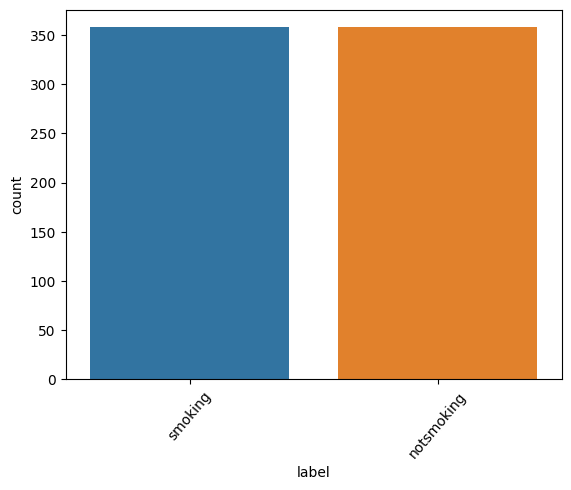

In [ ]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50)

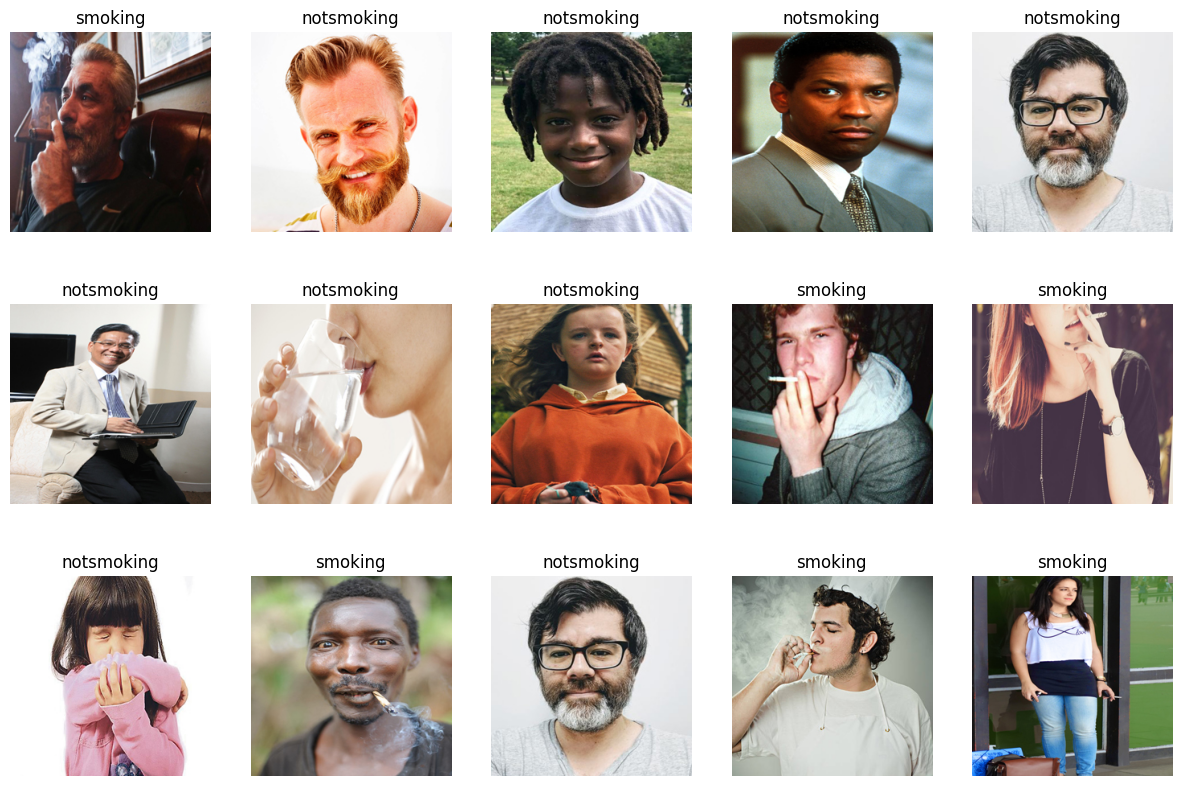

In [ ]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()


Create datasets and dataloader

In [ ]:
# 訓練集轉換
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5), # 以0.5的概率進行水平翻轉
    v2.RandomVerticalFlip(p=0.5), # 以0.5的概率進行垂直翻轉
    # v2.RandomRotation(degrees=(-20, 20)), # 隨機旋轉圖像
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 正規化操作
])
# 測試集轉換
test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        img = Image.open(image_path).convert("RGB")

        # 使用設定的 transforms 進行轉換
        transformed_img = self.transforms_(img)
        # 獲取圖像對應的類別ID
        class_id = self.df.iloc[index]['class_id']
        # 返回轉換後的圖像和對應的類別ID
        return transformed_img, class_id

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook

# 創建訓練和驗證集的資料集實例
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:716
val data:180


Create model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
class_size = len(label_list) # class_size = 2
# Use Swin Transformer (models.swin_v2_s)
model = models.swin_v2_s(weights='DEFAULT')
# 修改了模型的最後一層（head），將其輸出特徵數改為 class_size，以符合資料集的類別數量
model.head = nn.Linear(in_features=model.head.in_features, out_features=class_size)

# 將一個隨機生成的張量（大小為 (16, 3, 224, 224)）通過模型，然後查看輸出的形狀（shape）
model(torch.randn((16,3,224,224))).shape
# torch.Size([16, 2]): 每個批次（batch）有 16 個樣本，每個樣本有 2 個特徵（或類別）。這是一個二分類問題，模型的輸出有 2 個值，分別對應於每個類別的分數或概率。

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:03<00:00, 50.6MB/s]


torch.Size([16, 2])

Training and validataion

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = 0
    num_batches = len(dataloader) # 資料集被分成的批次數量
    model.train() # 將模型設置為訓練模式
    epoch_loss = 0.0 # 用於累積每個 epoch 的損失
    epoch_correct = 0 # 用於累積每個 epoch 的正確預測數量
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor) # 將標籤轉換為 LongTensor 類型
        data_, target_ = data_.to(device), target_.to(device) # 將數據和標籤移動到指定的裝置（GPU 或 CPU）

        # 首先清除優化器的梯度
        optimizer.zero_grad()

        # 前向傳播：計算模型的預測輸出，每一行對應一個樣本，每列對應一個類別的分數
        outputs = model(data_)

        # 計算損失：使用損失函數計算預測輸出和實際標籤之間的損失
        loss = loss_fn(outputs,target_)

        # 反向傳播：計算梯度
        loss.backward()

        # 優化模型：使用優化器來更新模型的權重
        optimizer.step()

        # 計算統計數據
        epoch_loss = epoch_loss + loss.item() # 累積損失

        # 找到每個樣本預測輸出中最高分數對應的類別索引(pred)
        _,pred = torch.max(outputs,dim=1)

        # 累積正確預測的數量
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()

        # size 會包含到目前為止的總樣本數量,target_.shape[0]是目前批次的樣本數量
        size += target_.shape[0]

    # 更新學習率
    lr_scheduler.step()

    # 返回準確率和平均損失
    return epoch_correct/size, epoch_loss/num_batches

In [ ]:
def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset) # number of samples
    size = 0
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():
        # 這會禁用反向傳播
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)

            # Computing loss
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
            size += target_.shape[0]
    return  epoch_correct/size, epoch_loss/num_batches

In [ ]:
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

# loss function
criterion  = nn.CrossEntropyLoss()

learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# 設定學習率調整的里程碑（milestones）和衰減因子（gamma)
# 學習率在每個里程碑處會變成原來的 0.1 倍
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)

for epoch in tqdm(range(EPOCHS)):
    # 訓練並獲取訓練準確率和損失
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    # 在驗證集上進行測試並獲取測試準確率和損失
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    # 每個 epoch 都保存模型的權重到 "checkpoints/last.pth"
    torch.save(model.state_dict(), "checkpoints/last.pth")

    # 檢查是否有模型改善，如果有就保存到 "checkpoints/best.pth"
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1

    # 如果模型在一定的 patience 內沒有改善，則提前結束訓練
    if counter >= patience:
        print("Earlystop!")
        break


  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.6902, train_acc: 0.566     val_loss: 0.6455, val_acc: 0.650     Learning Rate: 0.0001


  2%|▏         | 1/50 [00:29<24:03, 29.47s/it]

EPOCH: 1     train_loss: 0.6378, train_acc: 0.648     val_loss: 0.6123, val_acc: 0.706     Learning Rate: 0.0001


  4%|▍         | 2/50 [00:56<22:32, 28.18s/it]

EPOCH: 2     train_loss: 0.6467, train_acc: 0.634     val_loss: 0.6591, val_acc: 0.522     Learning Rate: 0.0001


  6%|▌         | 3/50 [01:24<21:45, 27.78s/it]

EPOCH: 3     train_loss: 0.5680, train_acc: 0.704     val_loss: 0.5448, val_acc: 0.772     Learning Rate: 0.0001


  8%|▊         | 4/50 [01:52<21:33, 28.12s/it]

EPOCH: 4     train_loss: 0.5516, train_acc: 0.716     val_loss: 0.3079, val_acc: 0.917     Learning Rate: 0.0001


 10%|█         | 5/50 [02:21<21:17, 28.38s/it]

EPOCH: 5     train_loss: 0.4442, train_acc: 0.782     val_loss: 0.2429, val_acc: 0.922     Learning Rate: 0.0001


 12%|█▏        | 6/50 [02:49<20:46, 28.34s/it]

EPOCH: 6     train_loss: 0.4682, train_acc: 0.802     val_loss: 0.3264, val_acc: 0.878     Learning Rate: 1e-05


 14%|█▍        | 7/50 [03:18<20:17, 28.32s/it]

EPOCH: 7     train_loss: 0.4133, train_acc: 0.818     val_loss: 0.2642, val_acc: 0.889     Learning Rate: 1e-05


 16%|█▌        | 8/50 [03:46<19:51, 28.38s/it]

EPOCH: 8     train_loss: 0.3409, train_acc: 0.865     val_loss: 0.2214, val_acc: 0.894     Learning Rate: 1e-05


 18%|█▊        | 9/50 [04:15<19:25, 28.44s/it]

EPOCH: 9     train_loss: 0.2870, train_acc: 0.876     val_loss: 0.2129, val_acc: 0.928     Learning Rate: 1e-05


 20%|██        | 10/50 [04:47<19:44, 29.62s/it]

EPOCH: 10     train_loss: 0.2892, train_acc: 0.869     val_loss: 0.1963, val_acc: 0.928     Learning Rate: 1e-05


 22%|██▏       | 11/50 [05:16<19:07, 29.43s/it]

EPOCH: 11     train_loss: 0.2914, train_acc: 0.881     val_loss: 0.1846, val_acc: 0.922     Learning Rate: 1e-05


 24%|██▍       | 12/50 [05:45<18:28, 29.18s/it]

EPOCH: 12     train_loss: 0.2787, train_acc: 0.872     val_loss: 0.1733, val_acc: 0.928     Learning Rate: 1e-05


 26%|██▌       | 13/50 [06:13<17:53, 29.01s/it]

EPOCH: 13     train_loss: 0.2169, train_acc: 0.901     val_loss: 0.1584, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [06:42<17:18, 28.85s/it]

EPOCH: 14     train_loss: 0.2534, train_acc: 0.894     val_loss: 0.1575, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [07:10<16:47, 28.78s/it]

EPOCH: 15     train_loss: 0.2249, train_acc: 0.916     val_loss: 0.1551, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [07:39<16:19, 28.81s/it]

EPOCH: 16     train_loss: 0.2431, train_acc: 0.898     val_loss: 0.1525, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [08:08<15:47, 28.70s/it]

EPOCH: 17     train_loss: 0.2310, train_acc: 0.898     val_loss: 0.1534, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [08:35<15:08, 28.38s/it]

EPOCH: 18     train_loss: 0.2255, train_acc: 0.904     val_loss: 0.1507, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [09:04<14:41, 28.43s/it]

EPOCH: 19     train_loss: 0.2273, train_acc: 0.902     val_loss: 0.1487, val_acc: 0.944     Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [09:32<14:15, 28.51s/it]

EPOCH: 20     train_loss: 0.2179, train_acc: 0.912     val_loss: 0.1457, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [10:01<13:49, 28.59s/it]

EPOCH: 21     train_loss: 0.2248, train_acc: 0.899     val_loss: 0.1454, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [10:30<13:19, 28.56s/it]

EPOCH: 22     train_loss: 0.2145, train_acc: 0.906     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [10:58<12:50, 28.53s/it]

EPOCH: 23     train_loss: 0.2274, train_acc: 0.909     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [11:26<12:15, 28.30s/it]

EPOCH: 24     train_loss: 0.2476, train_acc: 0.897     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [11:54<11:47, 28.29s/it]

EPOCH: 25     train_loss: 0.2344, train_acc: 0.898     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 52%|█████▏    | 26/50 [12:23<11:22, 28.43s/it]

EPOCH: 26     train_loss: 0.2243, train_acc: 0.920     val_loss: 0.1453, val_acc: 0.950     Learning Rate: 1.0000000000000002e-07


 54%|█████▍    | 27/50 [12:51<10:49, 28.25s/it]

EPOCH: 27     train_loss: 0.2301, train_acc: 0.906     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 56%|█████▌    | 28/50 [13:19<10:23, 28.36s/it]

EPOCH: 28     train_loss: 0.1982, train_acc: 0.919     val_loss: 0.1451, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 58%|█████▊    | 29/50 [13:48<09:56, 28.41s/it]

EPOCH: 29     train_loss: 0.2158, train_acc: 0.908     val_loss: 0.1451, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 60%|██████    | 30/50 [14:17<09:31, 28.56s/it]

EPOCH: 30     train_loss: 0.2463, train_acc: 0.887     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 62%|██████▏   | 31/50 [14:45<08:59, 28.41s/it]

EPOCH: 31     train_loss: 0.2044, train_acc: 0.915     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 64%|██████▍   | 32/50 [15:13<08:28, 28.25s/it]

EPOCH: 32     train_loss: 0.2243, train_acc: 0.901     val_loss: 0.1451, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 66%|██████▌   | 33/50 [15:41<07:57, 28.11s/it]

EPOCH: 33     train_loss: 0.2178, train_acc: 0.895     val_loss: 0.1451, val_acc: 0.950     Learning Rate: 1.0000000000000004e-08


 68%|██████▊   | 34/50 [16:08<07:28, 28.03s/it]

EPOCH: 34     train_loss: 0.2321, train_acc: 0.897     val_loss: 0.1452, val_acc: 0.950     Learning Rate: 1.0000000000000005e-09


 68%|██████▊   | 34/50 [16:37<07:49, 29.33s/it]

Earlystop!


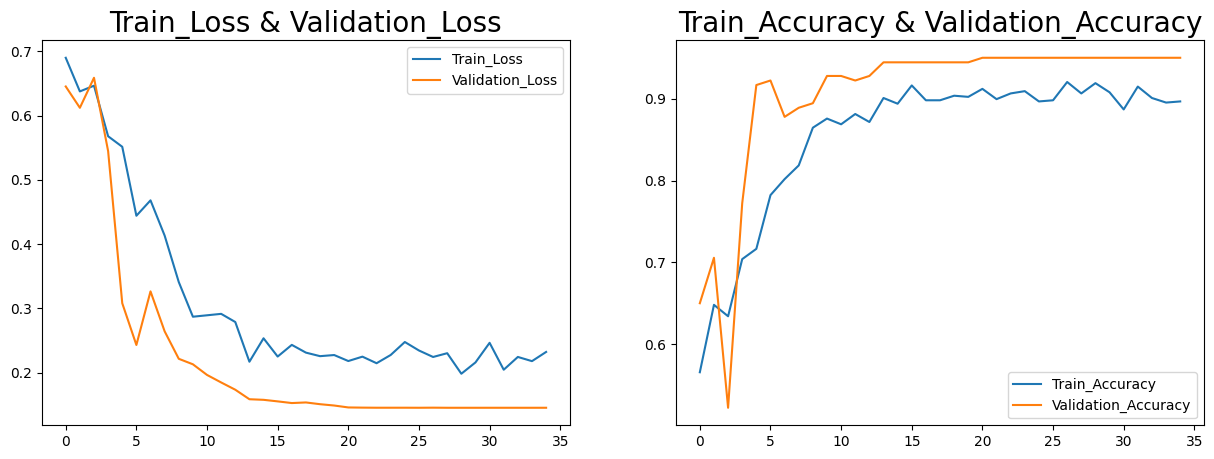

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/content/Testing/Testing'
img_list = glob(test_path+'/*.jpg')
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[0:len(label_list[0])] == label_list[0]:
        new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)
    elif file_name[0:len(label_list[1])] == label_list[1]:
        new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

test_dataset = MyDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


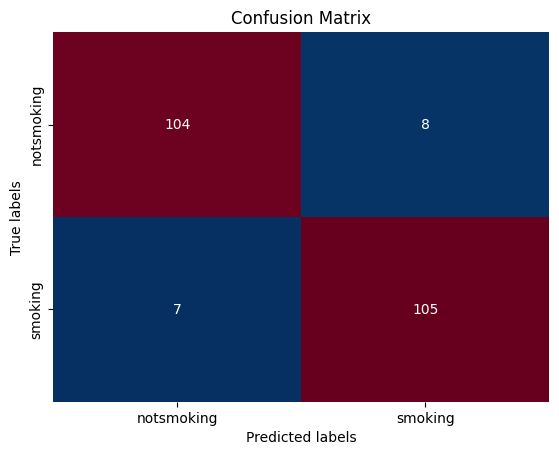

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
print(clf_report)

              precision    recall  f1-score   support

  notsmoking       0.94      0.93      0.93       112
     smoking       0.93      0.94      0.93       112

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224



In [ ]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()
